# Divvy Bike-Share Analysis Case Study

This case study is an optional part of the Google Data Analytics Certificate. I used SQL Server for data cleaning and exploring and used Tableau for the visualizations.

## Background

Divvy is a bike-share company in Chicago that features more than 5,800 bicycles and 600 docking stations. The company offers different types of bikes that caters to the customers needs. The company also offers pricing plans: single-ride passes, full-day passes, and annual memberships.

- Customers who purchase single-ride or full-day passes are referred to as **casual** riders.
- Customers who purchase annual memberships are Cyclistic **members**.

## Goal

The company has concluded that annual members are much more profitable than casual riders. The marketing team is aimed at converting casual riders into annual members using marketing strategies by understanding first how both riders differ.

## Phase 1: Ask

**Identify the business task:**

Using bike trip data, we need to identify trends and differences between the two types of riders. Share insights by having supporting visualizations and key findings to the marketing team in order to influence their marketing tactics.

## Phase 2: Prepare

**About the dataset**

I used 12 Months of Historical Trip Data starting from July 2021 to March 2022. This data is available to the public and is released on a monthly schedule. More information can be found [here](https://ride.divvybikes.com/system-data). The data has been made available by Motivate International Inc. under this [license](https://ride.divvybikes.com/data-license-agreement)

The data is anonymized and includes:

- Trip start day and time
- Trip end day and time
- Trip start station
- Trip end station
- Rider type (member or casual)
- Bike type

**Is it Reliable, Original, Comprehensive, Current, and Cited (ROCCC)?**

Since the data is a first-party data, we can ensure that it is reliable and original and cited. The chosen months of trip data is current. It is also comprehensive based on the detail of information given by the company.

**Downloading and storing data**

Since I am working with a large volume of data, I have decided to use SQL Server rather than Excel. After downloading each monthly trip.csv data, each file is imported into a table in SQL SERVER with its appropriate data types. All monthly trip data is combined to just one table having a total of **5860776** rows of data

In [30]:
-- combine monthly trip data into one table Trip_Data
SELECT * INTO [BikeTrip_CaseStudy].[dbo].Trip_Data FROM
(
SELECT * FROM [BikeTrip_CaseStudy].[dbo].TripData_2021_07
 UNION
SELECT * FROM [BikeTrip_CaseStudy].[dbo].TripData_2021_08
 UNION
SELECT * FROM [BikeTrip_CaseStudy].[dbo].TripData_2021_09
 UNION
SELECT * FROM [BikeTrip_CaseStudy].[dbo].TripData_2021_10
 UNION
SELECT * FROM [BikeTrip_CaseStudy].[dbo].TripData_2021_11
 UNION
SELECT * FROM [BikeTrip_CaseStudy].[dbo].TripData_2021_12
 UNION
SELECT * FROM [BikeTrip_CaseStudy].[dbo].TripData_2022_01
 UNION
SELECT * FROM [BikeTrip_CaseStudy].[dbo].TripData_2022_02
 UNION
SELECT * FROM [BikeTrip_CaseStudy].[dbo].TripData_2022_03
 UNION
SELECT * FROM [BikeTrip_CaseStudy].[dbo].TripData_2022_04
 UNION
SELECT * FROM [BikeTrip_CaseStudy].[dbo].TripData_2022_05
) tmp

: Msg 208, Level 16, State 1, Line 2
Invalid object name 'BikeTrip_CaseStudy.dbo.TripData_2021_08'.

Total execution time: 00:00:00.003

**Trip_data column overview**

- **ride_id** : id for each ride
- **rideable_type** : type of bike
- **started_at** : starting date and time of the trip
- **ended_at** : ending date and time of the trip
- **start_station_name** : name of the station where the trip was started
- **start_station_id** : id of the station where trip was started
- **end_station_name** : name of the station where the trip was ended
- **end_station_id** : id of the station where the trip was ended
- **start_lat** : latitude of the starting station
- **start_lng** : longitude ot the starting station
- **end_lat** : latitude of the starting station
- **end_lng** : longitude of the starting station
- **member_casual** : rider type

## Phase 3: Process

Now that all data is in one place we can start cleaning the data and adding columns that will help us in order to facilitate our analysis.

- I made 2 new columns including:
    - ride length of each trip in seconds
    - day of the week of each trip.

In [ ]:
-- Add new column for day of the week, ride length 
ALTER TABLE [BikeTrip_CaseStudy].[dbo].Trip_Data
ADD day_of_week varchar(20), duration_seconds int

-- calculate the ride length duration in seconds
UPDATE [BikeTrip_CaseStudy].[dbo].Trip_Data
SET duration_seconds = DATEDIFF(second,started_at,ended_at) 

-- convert starting date as day of the week
UPDATE [BikeTrip_CaseStudy].[dbo].Trip_Data
SET day_of_week = DATENAME(WEEKDAY, started_at)


- Upon checking the data, there are some rows with duration of negative values. I have decided to just delete all data with a duration less than 1 min since those may not have been actual trips while the sample size will stay large. I have also deleted rows with empty strings.

In [ ]:
-- delete all rows with empty strings = 1193477 rows
DELETE
FROM BikeTrip_CaseStudy..Trip_Data
WHERE (start_station_name = '')
	OR (start_station_id = '')
	OR (end_station_name = '')
	OR (end_station_id = '')
	OR (start_lat = '')
	OR (start_lng = '')
	OR (end_lat = '')
	OR (end_lng = '')

-- delete rows with less than 60 seconds = 64220 rows
DELETE
FROM BikeTrip_CaseStudy..Trip_Data
WHERE duration_seconds < 60

- The total rows is **4603079** after cleaning the data

## Phase 4: Analyze & Share

We have now cleaned and transfomed our data. It is now ready for analysis to gain some insights.

- Looking first rider type distribution

In [35]:
-- total count per rider type and count percentage
SELECT member_casual AS rider_type, COUNT(member_casual) AS type_count, COUNT(member_casual) * 100 / (select COUNT(*) FROM BikeTrip_CaseStudy..Trip_Data) AS type_percentage
FROM [BikeTrip_CaseStudy].[dbo].Trip_Data
GROUP BY member_casual

(2 rows affected)

Total execution time: 00:00:02.796

rider_type,type_count,type_percentage
member,2605689,56
casual,1997390,43


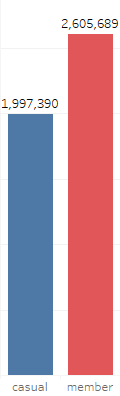

## Trip Duration

In [36]:
-- average duration in seconds for each type of member
SELECT member_casual AS ridertype, ROUND(AVG(CAST(duration_seconds AS float))/60,2) AS avg_duration_minutes
FROM [BikeTrip_CaseStudy].[dbo].Trip_Data
GROUP BY member_casual

(2 rows affected)

Total execution time: 00:00:02.281

ridertype,avg_duration_minutes
member,12.88
casual,30.43


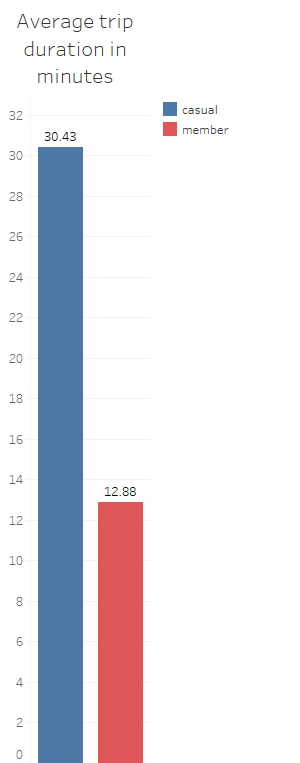

- the average trip duration of casuals is double of those members

# Trips per Day of the week

- How rider types differ per each day of the week

In [40]:
-- total rides per day of the week for casuals
SELECT COUNT(ride_id) as casuals_count, day_of_week
FROM [BikeTrip_CaseStudy].[dbo].Trip_Data
WHERE member_casual = 'casual'
GROUP BY day_of_week
ORDER BY casuals_count DESC

(7 rows affected)

Total execution time: 00:00:01.640

casuals_count,day_of_week
443183,Saturday
380317,Sunday
276930,Friday
234107,Thursday
231887,Monday
215790,Tuesday
215176,Wednesday


In [41]:
-- total rides per day of the week for members
SELECT COUNT(ride_id) as members_count, day_of_week
FROM [BikeTrip_CaseStudy].[dbo].Trip_Data
WHERE member_casual = 'member'
GROUP BY day_of_week
ORDER BY members_count DESC



(7 rows affected)

Total execution time: 00:00:01.820

members_count,day_of_week
418488,Tuesday
409007,Wednesday
396943,Thursday
369501,Monday
358307,Friday
344895,Saturday
308548,Sunday


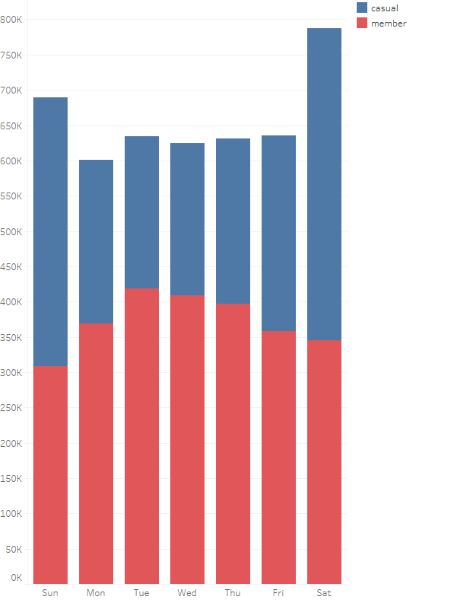

# Trips per Month

In [42]:
--total rides per month for casuals 
SELECT DATENAME(MONTH,started_at) AS month_name, COUNT(ride_id) AS casual_trips
FROM [BikeTrip_CaseStudy].[dbo].Trip_Data
WHERE member_casual = 'casual'
GROUP BY DATENAME(MONTH,started_at)
ORDER BY casual_trips DESC


(12 rows affected)

Total execution time: 00:00:01.845

month_name,casual_trips
July,365513
August,338138
June,300769
September,290078
May,216938
October,187324
April,90816
November,69267
March,66409
December,44684


In [43]:
--total rides per month for members 
SELECT DATENAME(MONTH,started_at) AS month_name, COUNT(ride_id) AS member_trips
FROM [BikeTrip_CaseStudy].[dbo].Trip_Data
WHERE member_casual = 'member'
GROUP BY DATENAME(MONTH,started_at)
ORDER BY member_trips DESC

(12 rows affected)

Total execution time: 00:00:02.064

month_name,member_trips
August,327946
September,323287
July,317690
June,299743
October,284140
May,277162
November,182922
April,177723
March,146497
December,129321


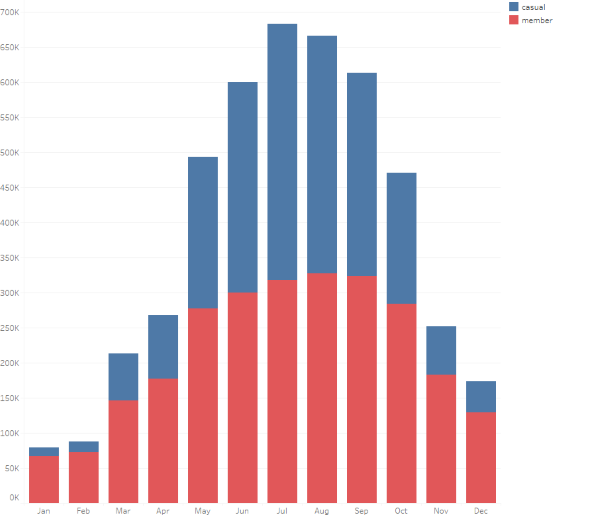

# Trips per Hour 
- looking at how many trips happen per each hour of the day

In [44]:
--total rides per hour for casuals
SELECT DATEPART(HOUR, started_at) as day_hour, COUNT(ride_id) as casual_count
FROM [BikeTrip_CaseStudy].[dbo].Trip_Data
WHERE member_casual = 'casual'
GROUP BY DATEPART(HOUR, started_at)
ORDER BY casual_count DESC

(24 rows affected)

Total execution time: 00:00:01.557

day_hour,casual_count
17,189980
18,171564
16,162629
15,147915
14,139271
13,135978
19,132057
12,128308
11,110049
20,95518


In [45]:
--total rides per hour for members
SELECT DATEPART(HOUR, started_at) as day_hour, COUNT(ride_id) as member_count
FROM [BikeTrip_CaseStudy].[dbo].Trip_Data
WHERE member_casual = 'member'
GROUP BY DATEPART(HOUR, started_at)
ORDER BY member_count DESC

(24 rows affected)

Total execution time: 00:00:01.683

day_hour,member_count
17,281993
18,230443
16,223955
15,165487
8,164807
19,162959
12,145925
13,142239
7,140864
14,139706


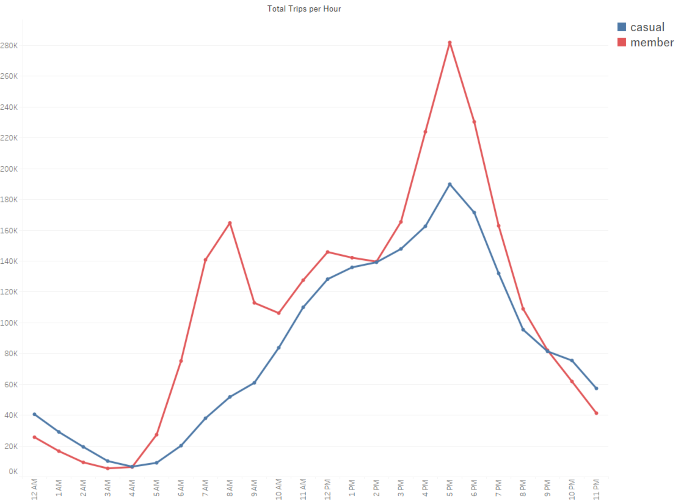

# Top Stations

- looking at stations use by casuals

In [46]:
-- total stations used by casuals and total trips for all stations
SELECT COUNT (DISTINCT start_station_name) AS stations_count, COUNT(start_station_name) AS total_stations_trips
FROM [BikeTrip_CaseStudy].[dbo].Trip_Data
WHERE member_casual = 'casual'



(1 row affected)

Total execution time: 00:00:01.762

stations_count,total_stations_trips
988,1997390


In [47]:
-- top 10 stations with highest count of starting trips for casuals
SELECT TOP (10 )start_station_name, COUNT(start_station_name) AS station_trips, ROUND((CONVERT(float,(COUNT(start_station_name)*100)) / (SELECT COUNT(*) FROM [BikeTrip_CaseStudy].[dbo].Trip_Data WHERE member_casual ='casual')), 2) AS station_percentage
FROM [BikeTrip_CaseStudy].[dbo].Trip_Data
WHERE member_casual = 'casual'
GROUP BY start_station_name
ORDER BY station_trips DESC

(10 rows affected)

Total execution time: 00:00:02.797

start_station_name,station_trips,station_percentage
Streeter Dr & Grand Ave,64525,3.23
Millennium Park,30085,1.51
Michigan Ave & Oak St,27724,1.39
DuSable Lake Shore Dr & Monroe St,22998,1.15
Shedd Aquarium,21813,1.09
Theater on the Lake,19879,1
DuSable Lake Shore Dr & North Blvd,18599,0.93
Wells St & Concord Ln,18547,0.93
Clark St & Lincoln Ave,15777,0.79
Wells St & Elm St,15329,0.77


- looking at station use by member

In [49]:
-- total stations used by members and total trips for all stations
SELECT COUNT (DISTINCT start_station_name) AS stations_count, COUNT(start_station_name) AS total_stations_trips
FROM [BikeTrip_CaseStudy].[dbo].Trip_Data
WHERE member_casual = 'member'

(1 row affected)

Total execution time: 00:00:01.999

stations_count,total_stations_trips
975,2605689


In [48]:
-- top 10 stations with highest count of starting trips for members
SELECT TOP (10 )start_station_name, COUNT(start_station_name) AS station_trips, ROUND((CONVERT(float,(COUNT(start_station_name)*100)) / (SELECT COUNT(*) FROM [BikeTrip_CaseStudy].[dbo].Trip_Data WHERE member_casual ='member')), 2) AS station_percentage
FROM [BikeTrip_CaseStudy].[dbo].Trip_Data
WHERE member_casual = 'member'
GROUP BY start_station_name
ORDER BY station_trips DESC

(10 rows affected)

Total execution time: 00:00:03.171

start_station_name,station_trips,station_percentage
Kingsbury St & Kinzie St,24726,0.95
Clark St & Elm St,23582,0.91
Wells St & Concord Ln,22841,0.88
Wells St & Elm St,19962,0.77
Dearborn St & Erie St,18215,0.7
Clinton St & Madison St,18152,0.7
Wells St & Huron St,17967,0.69
St. Clair St & Erie St,17751,0.68
Clinton St & Washington Blvd,17438,0.67
Broadway & Barry Ave,16708,0.64


### Member starting station heat map

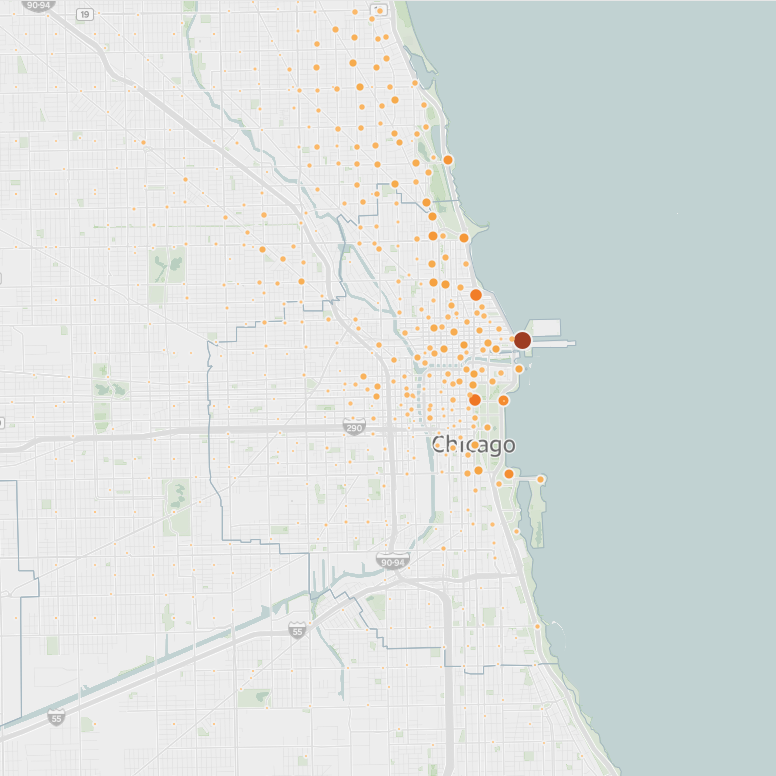

### Casual starting station heat map

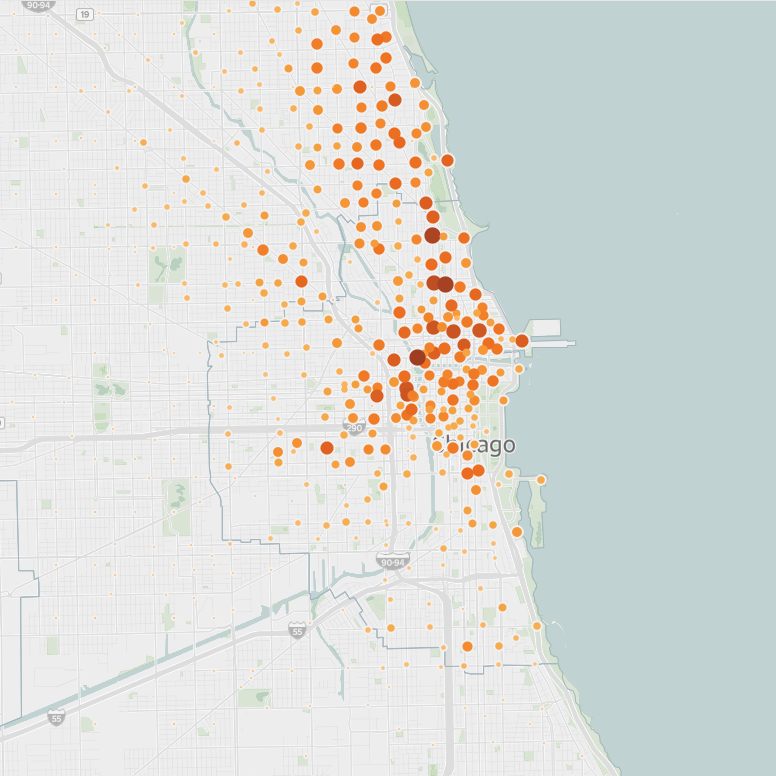

# Top Dates 
- looking at the dates with the highest count of trips for each rider type

In [31]:
-- Dates with the highest count of trips by CASUALS
SELECT TOP (10) CONVERT(DATE, started_at) AS trip_date, COUNT(ride_id) as num_rides, day_of_week
FROM [BikeTrip_CaseStudy].[dbo].Trip_Data
WHERE member_casual = 'casual'
GROUP BY CONVERT(DATE, started_at), day_of_week
ORDER BY num_rides DESC

(10 rows affected)

Total execution time: 00:00:01.991

trip_date,num_rides,day_of_week
2021-07-17,20098,Saturday
2021-08-14,20084,Saturday
2021-07-31,19757,Saturday
2021-07-04,19659,Sunday
2021-06-19,19459,Saturday
2021-08-07,19298,Saturday
2021-06-05,18882,Saturday
2021-06-13,18655,Sunday
2021-09-05,18592,Sunday
2021-07-03,18315,Saturday


- 4 out 10 of the top trip dates for casuals includes weekends where holidays are set: Sep 5th (Labor Day), June 19 (Juneteenth), July 3rd-4th (Independence day)

In [32]:
-- Dates with the highest count of trips by MEMBERS
SELECT TOP (10) CONVERT(DATE, started_at) AS trip_date, COUNT(ride_id) as num_rides, day_of_week
FROM [BikeTrip_CaseStudy].[dbo].Trip_Data
WHERE member_casual = 'member'
GROUP BY CONVERT(DATE, started_at), day_of_week
ORDER BY num_rides DESC

(10 rows affected)

Total execution time: 00:00:02.294

trip_date,num_rides,day_of_week
2022-05-19,12594,Thursday
2021-09-01,12552,Wednesday
2021-09-15,12457,Wednesday
2021-09-16,12448,Thursday
2021-10-19,12350,Tuesday
2021-09-09,12290,Thursday
2021-09-08,12279,Wednesday
2021-08-14,12231,Saturday
2021-09-29,12223,Wednesday
2022-05-10,12222,Tuesday


- Top trip dates for members are not set around holiday dates compared to casuals. 

## Phase 5: Act

## Key Findings

Based on my analysis, the data show:

1. Members tend to use the service more during weekedays while Casuals uses it more during weekends. Trip counts for casuals also increases to almost double during the weekends.
2. For members, two peak times occurs from 7AM to 8AM and from 5PM to 6PM. Casuals have only one peak time that occurs during 5PM to 6PM. A possible reason is that casual users uses the service more for leisure activities during the afternoon compared to members that uses the service as a means of transportation or commute for work or school.
3. Riders are influenced by temperature since there are less trips for both rider types during winter months which starts from December to March. A large volume of trips occur during July which is the hottest month of the year in Chicago.
4. Most casuals uses the service during holidays. 
5. Big portion of casual riders uses the Street Dr. and Grand Avenue Station which amounts to 3% of all trips by casuals.
6. Most casual riders uses stations that are near the Lake, while members starting station are concentrated in the downtown area.

## Recommendations

Some recommendations to encourage casual to become members:

1. Offer some kind of promotion for weekend-only or seasonal month type membership.
2. Post ads during the hours, months (Summer months), and days (holidays) where casual rides are increasing. 
3. Offer some kind of points-based incentives where members are given rewards the longer their total trip duration is. This is would encourage casuals since their average ride duration is double than members.
4. Show campaign ads on areas where top stations used by casuals are located. Partner with businesses that are located near those areas for campaigning.
5. Offer discounts or free trips for the first few months for current casuals that are converting to a member pricing plan.